In [7]:

# Core imports
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, metrics
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# Utility imports
from collections import Counter
from pathlib import Path


/tmp/ipykernel_218/2670004069.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="viridis")


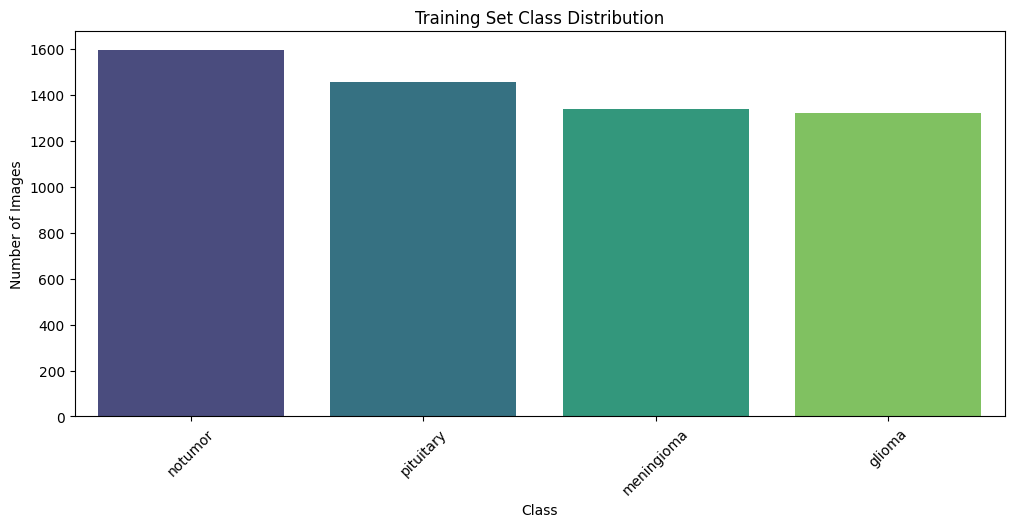

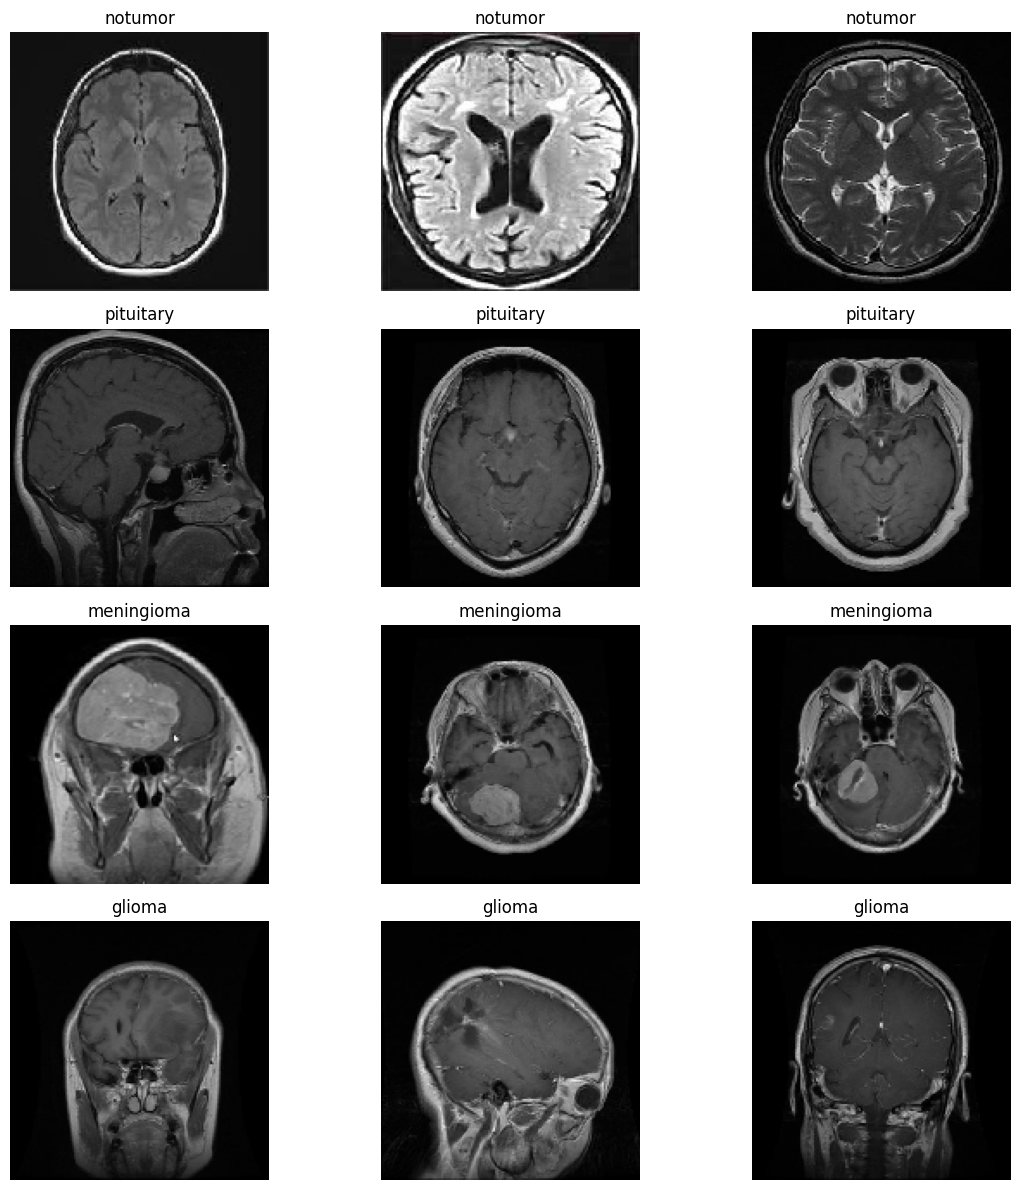

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define dataset paths
data_folder = 'Issam&Aymen/Brain/Brain_Tumor_Dataset'
train_path = Path(data_folder) / 'Training'
test_path = Path(data_folder) / 'Testing'


# Get class distribution
def get_class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

# Plot class distribution
train_distribution = get_class_distribution(train_path)
test_distribution = get_class_distribution(test_path)

plt.figure(figsize=(12, 5))
sns.barplot(x=list(train_distribution.keys()), y=list(train_distribution.values()), palette="viridis")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.title("Training Set Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Function to display sample images from each class
def show_sample_images(directory, num_samples=3):
    classes = os.listdir(directory)
    plt.figure(figsize=(12, len(classes) * 3))

    for i, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            image_files = os.listdir(class_path)
            sample_files = random.sample(image_files, min(num_samples, len(image_files)))

            for j, img_file in enumerate(sample_files):
                img_path = os.path.join(class_path, img_file)
                img = load_img(img_path, target_size=(150, 150))
                img_array = img_to_array(img) / 255.0

                plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
                plt.imshow(img_array)
                plt.title(class_name)
                plt.axis("off")
    plt.tight_layout()
    plt.show()

# Show sample images from training dataset
show_sample_images(train_path)


In [9]:
import os
import shutil
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter

# Image parameters
image_size = (224, 224)
batch_size = 32
SEED = 42

# Data Augmentation and Preprocessing for Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Apply generator to the original training dataset
train_generator = train_datagen.flow_from_directory(
    train_path,  # Use original directory without balancing
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    seed=SEED
)

# Preprocessing for Testing Data (No Augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=SEED
)

# Print class labels and class distribution
print("Class Labels:", train_generator.class_indices)
print("Class Distribution:", Counter(train_generator.classes))


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Class Labels: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Class Distribution: Counter({np.int32(2): 1595, np.int32(3): 1457, np.int32(1): 1339, np.int32(0): 1321})


In [21]:
from tensorflow.keras.models import load_model

# Load the saved model
model_path = "teacher_model(MobileNetV2).h5"
teacher_model = load_model(model_path)


Model Evaluation:


/opt/bitnami/miniforge/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9745 - loss: 0.0636
Test Accuracy: 98.02%


In [21]:
print("\nModel Evaluation:")
test_loss, test_acc = teacher_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


Model Evaluation:


/opt/bitnami/miniforge/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9745 - loss: 0.0636
Test Accuracy: 98.02%


In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def create_student_model(input_shape=(224, 224, 3), include_top=False, weights="imagenet",
                         alpha=1.0, dropout_rate=0.2):
    # Load MobileNetV2 as feature extractor with alpha (width multiplier)
    base_model = MobileNetV2(input_shape=input_shape, include_top=include_top, weights=weights,
                             alpha=alpha)
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(int(256 * alpha), activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(int(128 * alpha), activation="relu")(x)
    x = Dropout(dropout_rate)(x)
    predictions = Dense(4, activation="softmax")(x)

    student_model = Model(inputs=base_model.input, outputs=predictions)
    return student_model

# Define the search space parameters
alphas = [0.35, 0.5, 0.75, 1.0]  # Width multipliers (alpha) for the MobileNetV2 architecture
dropout_rates = [0.1, 0.2, 0.3, 0.5]  # Dropout rates for the fully connected layers


search_space = []
for alpha in alphas:
    for dropout in dropout_rates:
        student_model = create_student_model(alpha=alpha, dropout_rate=dropout)

        student_model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])
        search_space.append((student_model))

for idx, model in enumerate(search_space):
    print(f"Student Model {idx + 1}")
    model.summary()
    print("\n" + "=" * 50 + "\n")

Student Model 1


Model: "functional_1060"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_16[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56, 8) │        384 │ block_1_depthwis

 Total params: 528,357 (2.02 MB)

 Trainable params: 118,149 (461.52 KB)

 Non-trainable params: 410,208 (1.56 MB)



Student Model 2


Model: "functional_1061"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_17[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56, 8) │        384 │ block_1_depthwis

 Total params: 528,357 (2.02 MB)

 Trainable params: 118,149 (461.52 KB)

 Non-trainable params: 410,208 (1.56 MB)



Student Model 3


Model: "functional_1062"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_18[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56, 8) │        384 │ block_1_depthwis

 Total params: 528,357 (2.02 MB)

 Trainable params: 118,149 (461.52 KB)

 Non-trainable params: 410,208 (1.56 MB)



Student Model 4


Model: "functional_1063"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_19[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56, 8) │        384 │ block_1_depthwis

 Total params: 528,357 (2.02 MB)

 Trainable params: 118,149 (461.52 KB)

 Non-trainable params: 410,208 (1.56 MB)



Student Model 5


Model: "functional_1064"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_20[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │        768 │ block_1_depthwis

 Total params: 878,708 (3.35 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 706,224 (2.69 MB)



Student Model 6


Model: "functional_1065"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_21      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_21[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │        768 │ block_1_depthwis

 Total params: 878,708 (3.35 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 706,224 (2.69 MB)



Student Model 7


Model: "functional_1066"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_22[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │        768 │ block_1_depthwis

 Total params: 878,708 (3.35 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 706,224 (2.69 MB)



Student Model 8


Model: "functional_1067"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_23      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        432 │ input_layer_23[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         64 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (Conv2D)            │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         32 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │        384 │ expanded_conv_pr… │
│ (Conv2D)            │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        192 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        432 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        192 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │        768 │ block_1_depthwis

 Total params: 878,708 (3.35 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 706,224 (2.69 MB)



Student Model 9


Model: "functional_1068"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        648 │ input_layer_24[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,646,932 (6.28 MB)

 Trainable params: 264,868 (1.01 MB)

 Non-trainable params: 1,382,064 (5.27 MB)



Student Model 10


Model: "functional_1069"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        648 │ input_layer_25[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,646,932 (6.28 MB)

 Trainable params: 264,868 (1.01 MB)

 Non-trainable params: 1,382,064 (5.27 MB)



Student Model 11


Model: "functional_1070"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        648 │ input_layer_26[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,646,932 (6.28 MB)

 Trainable params: 264,868 (1.01 MB)

 Non-trainable params: 1,382,064 (5.27 MB)



Student Model 12


Model: "functional_1071"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        648 │ input_layer_27[0… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │         96 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        216 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         96 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        384 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 1,646,932 (6.28 MB)

 Trainable params: 264,868 (1.01 MB)

 Non-trainable params: 1,382,064 (5.27 MB)



Student Model 13


Model: "functional_1072"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_28      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_28[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)



Student Model 14


Model: "functional_1073"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_29      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_29[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)



Student Model 15


Model: "functional_1074"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_30[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)



Student Model 16


Model: "functional_1075"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_31      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_31[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,619,332 (9.99 MB)

 Trainable params: 361,348 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
import tensorflow as tf

def select_best_layers(model):

    layer_names = [layer.name for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D))]

    return [layer_names[-1], layer_names[9], layer_names[36]]


def compute_lrp_relevance(model, img, layer_name):

    img = tf.convert_to_tensor(img)

    grad_model = Model(inputs=model.input,
                       outputs=[model.get_layer(layer_name).output, model.output])

    with tf.GradientTape() as tape:
        features, preds = grad_model(img)
        top_class = tf.argmax(preds[0])
        one_hot = tf.one_hot(top_class, depth=preds.shape[-1])
        loss = tf.reduce_sum(preds * one_hot)

    grads = tape.gradient(loss, features)
    relevance = tf.multiply(features, grads)
    relevance = tf.reduce_sum(relevance, axis=-1)

    # Normalize relevance
    relevance = tf.nn.relu(relevance)
    max_val = tf.reduce_max(relevance, axis=[1, 2], keepdims=True) + 1e-10
    relevance = relevance / max_val

    return relevance.numpy()




def get_feature_maps(model, layer_name, input_tensor):

    try:
        input_tensor = tf.convert_to_tensor(input_tensor)
        intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
        feature_map = intermediate_layer_model.predict(input_tensor)

        return feature_map
    except ValueError:
        print(f" Warning: Layer '{layer_name}' not found in model {model.name}. Skipping.")
        return None


def compute_l2_distance(matrix1, matrix2):

    if matrix1 is None or matrix2 is None:
        return float('inf')

    return np.linalg.norm(matrix1 - matrix2)

def compute_feature_semantic_similarity(teacher_model, student_model, teacher_layer, student_layer, input_tensor):


    G_T = compute_lrp_relevance(teacher_model, input_tensor, teacher_layer)  # (B, H, W)
    G_S = compute_lrp_relevance(student_model, input_tensor, student_layer)

    if G_T is None or G_S is None:
        return float('inf')

    G_T_flat = G_T.reshape(G_T.shape[0], -1)
    G_S_flat = G_S.reshape(G_S.shape[0], -1)

    G_T_corr = np.dot(G_T_flat, G_T_flat.T) / (np.linalg.norm(G_T_flat) + 1e-10)
    G_S_corr = np.dot(G_S_flat, G_S_flat.T) / (np.linalg.norm(G_S_flat) + 1e-10)

    return np.linalg.norm(G_T_corr - G_S_corr)

def compute_sample_relation_similarity(teacher_model, student_model, teacher_layer, student_layer, input_tensor):

    A_T = get_feature_maps(teacher_model, teacher_layer, input_tensor)
    A_S = get_feature_maps(student_model, student_layer, input_tensor)

    if A_T is None or A_S is None:
        return float('inf')

    A_T_flat = A_T.reshape(A_T.shape[0], -1)
    A_S_flat = A_S.reshape(A_S.shape[0], -1)

    A_T_corr = np.dot(A_T_flat, A_T_flat.T) / (np.linalg.norm(A_T_flat))
    A_S_corr = np.dot(A_S_flat, A_S_flat.T) / (np.linalg.norm(A_S_flat))

    Mr = compute_l2_distance(A_T_corr, A_S_corr)
    return Mr


def compute_diswot_score_batch(teacher_model, student_model, teacher_layers, student_layers, input_tensors):

    batch_Ms = []
    batch_Mr = []

    for input_tensor in input_tensors:
        input_tensor = np.expand_dims(input_tensor, axis=0)

        for teacher_layer, student_layer in zip(teacher_layers, student_layers):
            Ms = compute_feature_semantic_similarity(teacher_model, student_model, teacher_layer, student_layer, input_tensor)
            Mr = compute_sample_relation_similarity(teacher_model, student_model, teacher_layer, student_layer, input_tensor)
            batch_Ms.append(Ms)
            batch_Mr.append(Mr)

    avg_Ms = np.mean(batch_Ms)
    avg_Mr = np.mean(batch_Mr)

    diswot_score = avg_Ms + avg_Mr
    return diswot_score


testing_folder = "Issam&Aymen/Brain/Brain_Tumor_Dataset/Testing"

def get_image_paths(folder):

    return [os.path.join(folder, img) for img in os.listdir(folder) if img.endswith(('.jpg', '.png'))]

glioma_images = get_image_paths(os.path.join(testing_folder, "glioma"))
meningioma_images = get_image_paths(os.path.join(testing_folder, "meningioma"))
pituitary_images = get_image_paths(os.path.join(testing_folder, "pituitary"))
notumor_images = get_image_paths(os.path.join(testing_folder, "notumor"))

assert len(glioma_images) > 0, "Error: No glioma images found!"
assert len(meningioma_images) > 0, "Error: No meningioma images found!"
assert len(pituitary_images) > 0, "Error: No pituitary images found!"
assert len(notumor_images) > 0, "Error: No notumor images found!"

def select_random_samples():

    selected_images = [
        random.choice(glioma_images),
        random.choice(meningioma_images),
        random.choice(pituitary_images),
        random.choice(notumor_images),
        random.choice(glioma_images + meningioma_images + pituitary_images + notumor_images)  # Random extra image
    ]
    return selected_images

random_test_images = select_random_samples()
print("Selected Test Images:", random_test_images)

def load_mini_batch(image_paths, img_size=(224, 224)):
    batch_images = []

    for img_path in image_paths:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)  # Apply MobileNetV2 preprocessing
        batch_images.append(img_array)

    return np.vstack(batch_images)  # Stack images into a batch


mini_batch = load_mini_batch(random_test_images)
print("Mini-batch shape:", mini_batch.shape)

student_scores = {}

for i, student_model in enumerate(search_space):

    teacher_layers = select_best_layers(teacher_model)
    student_layers = select_best_layers(student_model)

    score = compute_diswot_score_batch(teacher_model, student_model, teacher_layers, student_layers, mini_batch)

    student_scores[f"Student_{i}"] = (score, student_layers)
    print(f"Evaluated Student {i}: DisWOT Score = {score} (Student Layers: {student_layers})")

sorted_students = sorted(student_scores.items(), key=lambda x: x[1][0])

best_student_name, (best_score, best_layers) = sorted_students[0]
print(f"\nBest Student Model: {best_student_name} with DisWOT Score = {best_score} (Layers: {best_layers})")
sorted_students

Selected Test Images: ['Issam&Aymen/Brain/Brain_Tumor_Dataset/Testing/glioma/Te-glTr_0001.jpg', 'Issam&Aymen/Brain/Brain_Tumor_Dataset/Testing/meningioma/Te-me_0204.jpg', 'Issam&Aymen/Brain/Brain_Tumor_Dataset/Testing/pituitary/Te-pi_0102.jpg', 'Issam&Aymen/Brain/Brain_Tumor_Dataset/Testing/notumor/Te-no_0273.jpg', 'Issam&Aymen/Brain/Brain_Tumor_Dataset/Testing/meningioma/Te-me_0176.jpg']
Mini-batch shape: (5, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 908ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 911ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 940ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━

In [8]:
best_student = search_space[12]

In [9]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers import Adam

class DisWOTDistillerLPR(tf.keras.Model):
    def __init__(self, teacher, student, alpha_layers, temperature=4):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.temperature = temperature
        self.alpha_layers = alpha_layers

        self.ce_loss_weight = 0.3
        self.kl_loss_weight = 0.3
        self.semantic_loss_weight = 0.2
        self.relation_loss_weight = 0.2

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.ce_loss_tracker = tf.keras.metrics.Mean(name="ce_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.sem_loss_tracker = tf.keras.metrics.Mean(name="semantic_loss")
        self.rel_loss_tracker = tf.keras.metrics.Mean(name="relation_loss")

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer)
        self.student_metrics = metrics

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.ce_loss_tracker,
            self.kl_loss_tracker,
            self.sem_loss_tracker,
            self.rel_loss_tracker,
        ] + self.student_metrics

    def extract_features(self, model, layer_names):
        outputs = [model.get_layer(name).output for name in layer_names]
        return tf.keras.Model(inputs=model.input, outputs=outputs)

    def compute_lrp_relevance(self, model, x, layer_name):
        with tf.GradientTape() as tape:
            layer_output = model.get_layer(layer_name).output
            sub_model = tf.keras.Model(inputs=model.input, outputs=[layer_output, model.output])
            features, logits = sub_model(x, training=False)

            # Take relevance as element-wise product between activation and gradient of top class
            top_class = tf.argmax(logits, axis=1)
            one_hot = tf.one_hot(top_class, depth=logits.shape[-1])
            loss = tf.reduce_sum(logits * one_hot, axis=1)

        grads = tape.gradient(loss, features)
        relevance = tf.multiply(features, grads)
        relevance = tf.reduce_sum(relevance, axis=-1)  # Remove channel dimension
        relevance = tf.nn.relu(relevance)
        relevance_max = tf.reduce_max(relevance, axis=[1, 2], keepdims=True) + 1e-10
        return relevance / relevance_max

    def compute_l2_distance(self, matrix1, matrix2):
        if matrix1 is None or matrix2 is None:
            return float('inf')
        return tf.norm(matrix1 - matrix2)

    def compute_semantic_loss(self, x):
        losses = []
        for t_layer, s_layer in self.alpha_layers:
            R_T = self.compute_lrp_relevance(self.teacher, x, t_layer)
            R_S = self.compute_lrp_relevance(self.student, x, s_layer)
            R_T_flat = tf.reshape(R_T, [tf.shape(R_T)[0], -1])
            R_S_flat = tf.reshape(R_S, [tf.shape(R_S)[0], -1])
            sample_loss = self.compute_l2_distance(R_T_flat, R_S_flat)
            losses.append(tf.reduce_mean(sample_loss))
        return tf.reduce_mean(losses)

    def compute_relation_loss(self, teacher_feats, student_feats):
        losses = []
        for t_feat, s_feat in zip(teacher_feats, student_feats):
            batch_size = tf.shape(t_feat)[0]
            t_flat = tf.reshape(t_feat, [batch_size, -1])
            s_flat = tf.reshape(s_feat, [batch_size, -1])
            t_rel = tf.linalg.matmul(t_flat, t_flat, transpose_b=True)
            s_rel = tf.linalg.matmul(s_flat, s_flat, transpose_b=True)
            t_rel = tf.math.l2_normalize(t_rel, axis=-1)
            s_rel = tf.math.l2_normalize(s_rel, axis=-1)
            losses.append(tf.reduce_mean(tf.square(t_rel - s_rel)))
        return tf.reduce_mean(losses)

    def train_step(self, data):
        x, y = data

        teacher_preds = self.teacher(x, training=False)
        student_preds = self.student(x, training=True)

        teacher_layer_names, student_layer_names = zip(*self.alpha_layers)
        teacher_extractor = self.extract_features(self.teacher, teacher_layer_names)
        student_extractor = self.extract_features(self.student, student_layer_names)

        teacher_feats = teacher_extractor(x, training=False)
        student_feats = student_extractor(x, training=True)

        ce_loss = CategoricalCrossentropy()(y, student_preds)
        kl_loss = KLDivergence()(
            tf.nn.softmax(teacher_preds / self.temperature),
            tf.nn.softmax(student_preds / self.temperature)
        )
        sem_loss = self.compute_semantic_loss(x)
        rel_loss = self.compute_relation_loss(teacher_feats, student_feats)

        total_loss = (self.ce_loss_weight * ce_loss +
                      self.kl_loss_weight * kl_loss +
                      self.semantic_loss_weight * sem_loss +
                      self.relation_loss_weight * rel_loss)

        with tf.GradientTape() as tape:
            student_preds = self.student(x, training=True)
            teacher_preds = self.teacher(x, training=False)
            teacher_feats = teacher_extractor(x, training=False)
            student_feats = student_extractor(x, training=True)

            ce_loss = CategoricalCrossentropy()(y, student_preds)
            kl_loss = KLDivergence()(
                tf.nn.softmax(teacher_preds / self.temperature),
                tf.nn.softmax(student_preds / self.temperature)
            )
            sem_loss = self.compute_semantic_loss(x)
            rel_loss = self.compute_relation_loss(teacher_feats, student_feats)

            total_loss = (self.ce_loss_weight * ce_loss +
                          self.kl_loss_weight * kl_loss +
                          self.semantic_loss_weight * sem_loss +
                          self.relation_loss_weight * rel_loss)

        gradients = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.ce_loss_tracker.update_state(ce_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.sem_loss_tracker.update_state(sem_loss)
        self.rel_loss_tracker.update_state(rel_loss)

        for metric in self.student_metrics:
            metric.update_state(y, student_preds)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        student_preds = self.student(x, training=False)
        for metric in self.student_metrics:
            metric.update_state(y, student_preds)
        return {m.name: m.result() for m in self.student_metrics}



def select_best_layers(model):

    layer_names = [layer.name for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D))]

    return [layer_names[-1], layer_names[9], layer_names[36]]

teacher_layers = select_best_layers(teacher_model)
student_layers = select_best_layers(best_student)
alpha_layers = list(zip(teacher_layers, student_layers))

distiller = DisWOTDistillerLPR(
    teacher=teacher_model,
    student=best_student,
    alpha_layers=alpha_layers,
    temperature=4
)

distiller.compile(
    optimizer=Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

history = distiller.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 2:48:58 57s/step - accuracy: 0.2500 - ce_loss: 1.4832 - kl_loss: 0.0063 - relation_loss: 0.0000e+00 - semantic_loss: 21.7418 - total_loss: 4.7952

2025-05-05 20:52:03.218980: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 392 bytes spill stores, 384 bytes spill loads



171/179 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step - accuracy: 0.4409 - ce_loss: 1.2569 - kl_loss: 0.0055 - relation_loss: 0.0000e+00 - semantic_loss: 21.6671 - total_loss: 4.7121 

2025-05-05 20:52:54.224858: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 392 bytes spill stores, 384 bytes spill loads



179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.4463 - ce_loss: 1.2495 - kl_loss: 0.0055 - relation_loss: 0.0000e+00 - semantic_loss: 21.6400 - total_loss: 4.7045

2025-05-05 20:52:57.186963: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178', 16 bytes spill stores, 16 bytes spill loads

2025-05-05 20:52:57.262840: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178_0', 104 bytes spill stores, 136 bytes spill loads

2025-05-05 20:52:57.340910: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178', 228 bytes spill stores, 228 bytes spill loads

2025-05-05 20:53:00.485861: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1178', 16 bytes spill stores, 16 bytes spill loads

2025-05-05 20:53:00.604135: I external/local_xla/xla/s

179/179 ━━━━━━━━━━━━━━━━━━━━ 115s 327ms/step - accuracy: 0.4470 - ce_loss: 1.2486 - kl_loss: 0.0055 - relation_loss: 0.0000e+00 - semantic_loss: 21.6367 - total_loss: 4.7035 - val_accuracy: 0.7162 - learning_rate: 1.0000e-04
Epoch 2/15


/opt/bitnami/miniforge/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,ce_loss,kl_loss,relation_loss,semantic_loss,total_loss,val_accuracy
  current = self.get_monitor_value(logs)
/opt/bitnami/miniforge/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,ce_loss,kl_loss,relation_loss,semantic_loss,total_loss,val_accuracy,learning_rate.
  callback.on_epoch_end(epoch, logs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 190ms/step - accuracy: 0.7330 - ce_loss: 0.8208 - kl_loss: 0.0035 - relation_loss: 0.0000e+00 - semantic_loss: 19.3683 - total_loss: 4.1210 - val_accuracy: 0.7719 - learning_rate: 1.0000e-04
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 189ms/step - accuracy: 0.7672 - ce_loss: 0.7386 - kl_loss: 0.0030 - relation_loss: 0.0000e+00 - semantic_loss: 18.5435 - total_loss: 3.9312 - val_accuracy: 0.8101 - learning_rate: 1.0000e-04
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.8040 - ce_loss: 0.6456 - kl_loss: 0.0026 - relation_loss: 0.0000e+00 - semantic_loss: 17.7690 - total_loss: 3.7483 - val_accuracy: 0.8398 - learning_rate: 1.0000e-04
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 188ms/step - accuracy: 0.8193 - ce_loss: 0.5978 - kl_loss: 0.0024 - relation_loss: 0.0000e+00 - semantic_loss: 17.4725 - total_loss: 3.6745 - val_accuracy: 0.7895 - learning_rate: 1.0000e-04
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.77

41/41 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step


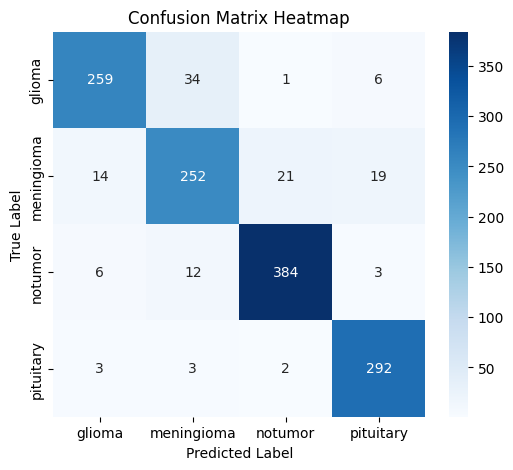

Classification Report:
               precision    recall  f1-score   support

      glioma       0.92      0.86      0.89       300
  meningioma       0.84      0.82      0.83       306
     notumor       0.94      0.95      0.94       405
   pituitary       0.91      0.97      0.94       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.91      0.91      0.90      1311



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

class_names = list(test_generator.class_indices.keys())

y_pred_probs = distiller.student.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

In [11]:
distiller.save('best_Student (LRP_91).h5')

In [13]:
best_student2 = search_space[12]

In [14]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers import Adam

class DisWOTDistillerLPR(tf.keras.Model):
    def __init__(self, teacher, student, alpha_layers, temperature=4):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.temperature = temperature
        self.alpha_layers = alpha_layers

        self.ce_loss_weight = 0.3
        self.kl_loss_weight = 0.3
        self.semantic_loss_weight = 0.2
        self.relation_loss_weight = 0.2

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.ce_loss_tracker = tf.keras.metrics.Mean(name="ce_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.sem_loss_tracker = tf.keras.metrics.Mean(name="semantic_loss")
        self.rel_loss_tracker = tf.keras.metrics.Mean(name="relation_loss")

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer)
        self.student_metrics = metrics

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.ce_loss_tracker,
            self.kl_loss_tracker,
            self.sem_loss_tracker,
            self.rel_loss_tracker,
        ] + self.student_metrics

    def extract_features(self, model, layer_names):
        outputs = [model.get_layer(name).output for name in layer_names]
        return tf.keras.Model(inputs=model.input, outputs=outputs)

    def compute_lrp_relevance(self, model, x, layer_name):
        with tf.GradientTape() as tape:
            layer_output = model.get_layer(layer_name).output
            sub_model = tf.keras.Model(inputs=model.input, outputs=[layer_output, model.output])
            features, logits = sub_model(x, training=False)

            # Take relevance as element-wise product between activation and gradient of top class
            top_class = tf.argmax(logits, axis=1)
            one_hot = tf.one_hot(top_class, depth=logits.shape[-1])
            loss = tf.reduce_sum(logits * one_hot, axis=1)

        grads = tape.gradient(loss, features)
        relevance = tf.multiply(features, grads)
        relevance = tf.reduce_sum(relevance, axis=-1)  # Remove channel dimension
        relevance = tf.nn.relu(relevance)
        relevance_max = tf.reduce_max(relevance, axis=[1, 2], keepdims=True) + 1e-10
        return relevance / relevance_max

    def compute_cosine_distance(self, vec1, vec2, epsilon=1e-10):
      dot_product = tf.reduce_sum(vec1 * vec2, axis=1)
      norm1 = tf.norm(vec1, axis=1)
      norm2 = tf.norm(vec2, axis=1)
      cosine_similarity = dot_product / (norm1 * norm2 + epsilon)
      return 1.0 - cosine_similarity

    def compute_semantic_loss(self, x):
      losses = []
      for t_layer, s_layer in self.alpha_layers:
        R_T = self.compute_lrp_relevance(self.teacher, x, t_layer)
        R_S = self.compute_lrp_relevance(self.student, x, s_layer)

        R_T_flat = tf.reshape(R_T, [tf.shape(R_T)[0], -1])
        R_S_flat = tf.reshape(R_S, [tf.shape(R_S)[0], -1])

        sample_losses = self.compute_cosine_distance(R_T_flat, R_S_flat)
        losses.append(tf.reduce_mean(sample_losses))
      return tf.reduce_mean(losses)

    def compute_relation_loss(self, teacher_feats, student_feats):
      losses = []
      for t_feat, s_feat in zip(teacher_feats, student_feats):



        B = tf.shape(t_feat)[0]
        t_flat = tf.reshape(t_feat, [B, -1])
        s_flat = tf.reshape(s_feat, [B, -1])


        t_flat = tf.math.l2_normalize(t_flat, axis=1)
        s_flat = tf.math.l2_normalize(s_flat, axis=1)


        t_corr = tf.matmul(t_flat, t_flat, transpose_b=True)
        s_corr = tf.matmul(s_flat, s_flat, transpose_b=True)


        t_corr_flat = tf.reshape(t_corr, [B, -1])
        s_corr_flat = tf.reshape(s_corr, [B, -1])
        rel_loss = self.compute_cosine_distance(t_corr_flat, s_corr_flat)

        losses.append(tf.reduce_mean(rel_loss))

      return tf.reduce_mean(losses)

    def train_step(self, data):
        x, y = data

        teacher_preds = self.teacher(x, training=False)
        student_preds = self.student(x, training=True)

        teacher_layer_names, student_layer_names = zip(*self.alpha_layers)
        teacher_extractor = self.extract_features(self.teacher, teacher_layer_names)
        student_extractor = self.extract_features(self.student, student_layer_names)

        teacher_feats = teacher_extractor(x, training=False)
        student_feats = student_extractor(x, training=True)

        ce_loss = CategoricalCrossentropy()(y, student_preds)
        kl_loss = KLDivergence()(
            tf.nn.softmax(teacher_preds / self.temperature),
            tf.nn.softmax(student_preds / self.temperature)
        )
        sem_loss = self.compute_semantic_loss(x)
        rel_loss = self.compute_relation_loss(teacher_feats, student_feats)

        total_loss = (self.ce_loss_weight * ce_loss +
                      self.kl_loss_weight * kl_loss +
                      self.semantic_loss_weight * sem_loss +
                      self.relation_loss_weight * rel_loss)

        with tf.GradientTape() as tape:
            student_preds = self.student(x, training=True)
            teacher_preds = self.teacher(x, training=False)
            teacher_feats = teacher_extractor(x, training=False)
            student_feats = student_extractor(x, training=True)

            ce_loss = CategoricalCrossentropy()(y, student_preds)
            kl_loss = KLDivergence()(
                tf.nn.softmax(teacher_preds / self.temperature),
                tf.nn.softmax(student_preds / self.temperature)
            )
            sem_loss = self.compute_semantic_loss(x)
            rel_loss = self.compute_relation_loss(teacher_feats, student_feats)

            total_loss = (self.ce_loss_weight * ce_loss +
                          self.kl_loss_weight * kl_loss +
                          self.semantic_loss_weight * sem_loss +
                          self.relation_loss_weight * rel_loss)

        gradients = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.ce_loss_tracker.update_state(ce_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.sem_loss_tracker.update_state(sem_loss)
        self.rel_loss_tracker.update_state(rel_loss)

        for metric in self.student_metrics:
            metric.update_state(y, student_preds)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        student_preds = self.student(x, training=False)
        for metric in self.student_metrics:
            metric.update_state(y, student_preds)
        return {m.name: m.result() for m in self.student_metrics}



def select_best_layers(model):

    layer_names = [layer.name for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D))]

    return [layer_names[-1], layer_names[9], layer_names[36]]

teacher_layers = select_best_layers(teacher_model)
student_layers = select_best_layers(best_student2)
alpha_layers = list(zip(teacher_layers, student_layers))

distiller = DisWOTDistillerLPR(
    teacher=teacher_model,
    student=best_student2,
    alpha_layers=alpha_layers,
    temperature=4
)

distiller.compile(
    optimizer=Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

history = distiller.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 2:49:24 57s/step - accuracy: 0.8125 - ce_loss: 0.4303 - kl_loss: 0.0015 - relation_loss: -4.8429e-08 - semantic_loss: 0.3942 - total_loss: 0.2084

2025-05-05 21:07:24.920696: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 392 bytes spill stores, 384 bytes spill loads



 74/179 ━━━━━━━━━━━━━━━━━━━━ 20s 192ms/step - accuracy: 0.8989 - ce_loss: 0.2765 - kl_loss: 0.0010 - relation_loss: -4.1318e-08 - semantic_loss: 0.3441 - total_loss: 0.1521

2025-05-05 21:07:51.204684: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 392 bytes spill stores, 384 bytes spill loads



179/179 ━━━━━━━━━━━━━━━━━━━━ 107s 283ms/step - accuracy: 0.9069 - ce_loss: 0.2572 - kl_loss: 9.7589e-04 - relation_loss: -4.0449e-08 - semantic_loss: 0.3395 - total_loss: 0.1454 - val_accuracy: 0.8940 - learning_rate: 1.0000e-04
Epoch 2/15


/opt/bitnami/miniforge/lib/python3.12/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,ce_loss,kl_loss,relation_loss,semantic_loss,total_loss,val_accuracy
  current = self.get_monitor_value(logs)
/opt/bitnami/miniforge/lib/python3.12/site-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,ce_loss,kl_loss,relation_loss,semantic_loss,total_loss,val_accuracy,learning_rate.
  callback.on_epoch_end(epoch, logs)


179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9273 - ce_loss: 0.1990 - kl_loss: 7.7003e-04 - relation_loss: -3.9456e-08 - semantic_loss: 0.3245 - total_loss: 0.1248 - val_accuracy: 0.8917 - learning_rate: 1.0000e-04
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.9304 - ce_loss: 0.1876 - kl_loss: 7.0968e-04 - relation_loss: -3.7655e-08 - semantic_loss: 0.3202 - total_loss: 0.1205 - val_accuracy: 0.8909 - learning_rate: 1.0000e-04
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 196ms/step - accuracy: 0.9355 - ce_loss: 0.1699 - kl_loss: 6.7381e-04 - relation_loss: -3.8814e-08 - semantic_loss: 0.3133 - total_loss: 0.1138 - val_accuracy: 0.8673 - learning_rate: 1.0000e-04
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.9397 - ce_loss: 0.1588 - kl_loss: 6.2840e-04 - relation_loss: -3.9619e-08 - semantic_loss: 0.3119 - total_loss: 0.1102 - val_accuracy: 0.8909 - learning_rate: 1.0000e-04
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 195ms/step 

In [15]:
best_student12 = search_space[14]

In [16]:
import tensorflow as tf
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence
from tensorflow.keras.optimizers import Adam

class DisWOTDistillerLPR(tf.keras.Model):
    def __init__(self, teacher, student, alpha_layers, temperature=4):
        super().__init__()
        self.teacher = teacher
        self.student = student
        self.temperature = temperature
        self.alpha_layers = alpha_layers

        self.ce_loss_weight = 0.3
        self.kl_loss_weight = 0.3
        self.semantic_loss_weight = 0.2
        self.relation_loss_weight = 0.2

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.ce_loss_tracker = tf.keras.metrics.Mean(name="ce_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        self.sem_loss_tracker = tf.keras.metrics.Mean(name="semantic_loss")
        self.rel_loss_tracker = tf.keras.metrics.Mean(name="relation_loss")

    def compile(self, optimizer, metrics):
        super().compile(optimizer=optimizer)
        self.student_metrics = metrics

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.ce_loss_tracker,
            self.kl_loss_tracker,
            self.sem_loss_tracker,
            self.rel_loss_tracker,
        ] + self.student_metrics

    def extract_features(self, model, layer_names):
        outputs = [model.get_layer(name).output for name in layer_names]
        return tf.keras.Model(inputs=model.input, outputs=outputs)

    def compute_lrp_relevance(self, model, x, layer_name):
        with tf.GradientTape() as tape:
            layer_output = model.get_layer(layer_name).output
            sub_model = tf.keras.Model(inputs=model.input, outputs=[layer_output, model.output])
            features, logits = sub_model(x, training=False)

            # Take relevance as element-wise product between activation and gradient of top class
            top_class = tf.argmax(logits, axis=1)
            one_hot = tf.one_hot(top_class, depth=logits.shape[-1])
            loss = tf.reduce_sum(logits * one_hot, axis=1)

        grads = tape.gradient(loss, features)
        relevance = tf.multiply(features, grads)
        relevance = tf.reduce_sum(relevance, axis=-1)  # Remove channel dimension
        relevance = tf.nn.relu(relevance)
        relevance_max = tf.reduce_max(relevance, axis=[1, 2], keepdims=True) + 1e-10
        return relevance / relevance_max

    def compute_cosine_distance(self, vec1, vec2, epsilon=1e-10):
      dot_product = tf.reduce_sum(vec1 * vec2, axis=1)
      norm1 = tf.norm(vec1, axis=1)
      norm2 = tf.norm(vec2, axis=1)
      cosine_similarity = dot_product / (norm1 * norm2 + epsilon)
      return 1.0 - cosine_similarity

    def compute_semantic_loss(self, x):
      losses = []
      for t_layer, s_layer in self.alpha_layers:
        R_T = self.compute_lrp_relevance(self.teacher, x, t_layer)
        R_S = self.compute_lrp_relevance(self.student, x, s_layer)

        R_T_flat = tf.reshape(R_T, [tf.shape(R_T)[0], -1])
        R_S_flat = tf.reshape(R_S, [tf.shape(R_S)[0], -1])

        sample_losses = self.compute_cosine_distance(R_T_flat, R_S_flat)
        losses.append(tf.reduce_mean(sample_losses))
      return tf.reduce_mean(losses)

    def compute_relation_loss(self, teacher_feats, student_feats):
      losses = []
      for t_feat, s_feat in zip(teacher_feats, student_feats):



        B = tf.shape(t_feat)[0]
        t_flat = tf.reshape(t_feat, [B, -1])
        s_flat = tf.reshape(s_feat, [B, -1])


        t_flat = tf.math.l2_normalize(t_flat, axis=1)
        s_flat = tf.math.l2_normalize(s_flat, axis=1)


        t_corr = tf.matmul(t_flat, t_flat, transpose_b=True)
        s_corr = tf.matmul(s_flat, s_flat, transpose_b=True)


        t_corr_flat = tf.reshape(t_corr, [B, -1])
        s_corr_flat = tf.reshape(s_corr, [B, -1])
        rel_loss = self.compute_cosine_distance(t_corr_flat, s_corr_flat)

        losses.append(tf.reduce_mean(rel_loss))

      return tf.reduce_mean(losses)

    def train_step(self, data):
        x, y = data

        teacher_preds = self.teacher(x, training=False)
        student_preds = self.student(x, training=True)

        teacher_layer_names, student_layer_names = zip(*self.alpha_layers)
        teacher_extractor = self.extract_features(self.teacher, teacher_layer_names)
        student_extractor = self.extract_features(self.student, student_layer_names)

        teacher_feats = teacher_extractor(x, training=False)
        student_feats = student_extractor(x, training=True)

        ce_loss = CategoricalCrossentropy()(y, student_preds)
        kl_loss = KLDivergence()(
            tf.nn.softmax(teacher_preds / self.temperature),
            tf.nn.softmax(student_preds / self.temperature)
        )
        sem_loss = self.compute_semantic_loss(x)
        rel_loss = self.compute_relation_loss(teacher_feats, student_feats)

        total_loss = (self.ce_loss_weight * ce_loss +
                      self.kl_loss_weight * kl_loss +
                      self.semantic_loss_weight * sem_loss +
                      self.relation_loss_weight * rel_loss)

        with tf.GradientTape() as tape:
            student_preds = self.student(x, training=True)
            teacher_preds = self.teacher(x, training=False)
            teacher_feats = teacher_extractor(x, training=False)
            student_feats = student_extractor(x, training=True)

            ce_loss = CategoricalCrossentropy()(y, student_preds)
            kl_loss = KLDivergence()(
                tf.nn.softmax(teacher_preds / self.temperature),
                tf.nn.softmax(student_preds / self.temperature)
            )
            sem_loss = self.compute_semantic_loss(x)
            rel_loss = self.compute_relation_loss(teacher_feats, student_feats)

            total_loss = (self.ce_loss_weight * ce_loss +
                          self.kl_loss_weight * kl_loss +
                          self.semantic_loss_weight * sem_loss +
                          self.relation_loss_weight * rel_loss)

        gradients = tape.gradient(total_loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        self.total_loss_tracker.update_state(total_loss)
        self.ce_loss_tracker.update_state(ce_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.sem_loss_tracker.update_state(sem_loss)
        self.rel_loss_tracker.update_state(rel_loss)

        for metric in self.student_metrics:
            metric.update_state(y, student_preds)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        student_preds = self.student(x, training=False)
        for metric in self.student_metrics:
            metric.update_state(y, student_preds)
        return {m.name: m.result() for m in self.student_metrics}



def select_best_layers(model):

    layer_names = [layer.name for layer in model.layers if isinstance(layer, (tf.keras.layers.Conv2D, tf.keras.layers.DepthwiseConv2D))]

    return [layer_names[-1], layer_names[9], layer_names[36]]

teacher_layers = select_best_layers(teacher_model)
student_layers = select_best_layers(best_student12)
alpha_layers = list(zip(teacher_layers, student_layers))

distiller = DisWOTDistillerLPR(
    teacher=teacher_model,
    student=best_student12,
    alpha_layers=alpha_layers,
    temperature=4
)

distiller.compile(
    optimizer=Adam(learning_rate=0.0001),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='accuracy')]
)

history = distiller.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
    ]
)

Epoch 1/15
  1/179 ━━━━━━━━━━━━━━━━━━━━ 2:50:54 58s/step - accuracy: 0.2812 - ce_loss: 1.7195 - kl_loss: 0.0067 - relation_loss: -3.9116e-08 - semantic_loss: 0.6172 - total_loss: 0.6413

2025-05-05 21:18:47.880977: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 392 bytes spill stores, 384 bytes spill loads



 26/179 ━━━━━━━━━━━━━━━━━━━━ 1:36 630ms/step - accuracy: 0.3114 - ce_loss: 1.5398 - kl_loss: 0.0066 - relation_loss: -3.7009e-08 - semantic_loss: 0.6254 - total_loss: 0.5890

2025-05-05 21:19:03.638131: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion', 392 bytes spill stores, 384 bytes spill loads



179/179 ━━━━━━━━━━━━━━━━━━━━ 108s 280ms/step - accuracy: 0.5256 - ce_loss: 1.1115 - kl_loss: 0.0048 - relation_loss: -3.7303e-08 - semantic_loss: 0.5863 - total_loss: 0.4521 - val_accuracy: 0.7895 - learning_rate: 1.0000e-04
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 192ms/step - accuracy: 0.8142 - ce_loss: 0.5159 - kl_loss: 0.0022 - relation_loss: -4.1266e-08 - semantic_loss: 0.4876 - total_loss: 0.2529 - val_accuracy: 0.8002 - learning_rate: 1.0000e-04
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 34s 187ms/step - accuracy: 0.8502 - ce_loss: 0.4158 - kl_loss: 0.0017 - relation_loss: -3.9410e-08 - semantic_loss: 0.4468 - total_loss: 0.2146 - val_accuracy: 0.8078 - learning_rate: 1.0000e-04
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 186ms/step - accuracy: 0.8580 - ce_loss: 0.3629 - kl_loss: 0.0015 - relation_loss: -3.9358e-08 - semantic_loss: 0.4192 - total_loss: 0.1932 - val_accuracy: 0.8444 - learning_rate: 1.0000e-04
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - accuracy: 0.8